# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

##### Imports

In [36]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset load and pre-process

In [37]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

# Random seed for reproducibility
seed = 0
np.random.seed(seed=seed)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0) ## SHOULD WE CHANGE THE SEED?

# Task 1 (Classifiers and fairness considerations)
### White-box model: Logistic Regression

In [50]:
class FairnessReport:

    def __init__(self):
        pass

    def fit(self, y_true, y_pred, group, pred_prob=None):
        
        # Create a DF with the each prediction, including group, prediction (selected) and target (true label)
        self.results_table = pd.DataFrame()
        self.results_table["group"] = group
        self.results_table["target"] = y_true
        self.results_table["selected"] = y_pred
        if type(pred_prob) != None:
            self.results_table["pred_prob"] = pred_prob[:,1]
    
    def compute(self):

        # Extract TPR and FPR per group
        rates = {1: {}, 2: {}}

        # Colormaps
        colors = [plt.cm.Blues, plt.cm.Reds]

        # Plot confusion matrices for context
        fig, ax = plt.subplots(2, 2, figsize=(12,12))

        # Populate the subplots
        for ix in range(2):
            group = ix+1 # Group code (1: Male, 2: Female)
            # Compute the confusion matrix
            cm = confusion_matrix(self.results_table.loc[self.results_table.group == group, "target"], self.results_table.loc[self.results_table.group == group, "selected"],
                                                        normalize=None)
            # Compute the row-wise normalized matrix
            cm_norm = confusion_matrix(self.results_table.loc[self.results_table.group == group, "target"], self.results_table.loc[self.results_table.group == group, "selected"],
                                                        normalize="true")
            # Extract True Positive Rate (TPR) and False Positive Rate (FPR) from the Confusion Matrix
            rates[group]["TPR"] = cm_norm[1,1]
            rates[group]["FPR"] = cm_norm[0,1]

            # Display both CMs
            disp1 = ConfusionMatrixDisplay(cm)
            disp2 = ConfusionMatrixDisplay(cm_norm)
            disp1.plot(cmap=colors[ix], ax=ax[ix,0])
            disp2.plot(cmap=colors[ix], ax=ax[ix,1])
            ax[ix,0].set_title(f'Group {group}')
            ax[ix,1].set_title(f'Group {group} - Row Norm.')
            
        ax[0,0].set_xlabel("")
        ax[0,1].set_xlabel("")
        ax[0,1].set_ylabel("")
        ax[1,1].set_ylabel("")
        fig.suptitle("Confusion Matrices per Group", fontweight='bold')
        plt.show();

        # Statistical parity: Prob. of being selected given the group
        ## Per each group, we look at the number of TRUE Predictions and divide by the total number of people in that group
        G1 = len(self.results_table.loc[(self.results_table.group == 1) & (self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 1)])
        G2 = len(self.results_table.loc[(self.results_table.group == 2) & (self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 2)])
        print(f"Statistical Parity: {G1 == G2} -> (P(s=1 | G=1): {G1:.3f} & P(s=1 | G=2): {G2:.3f})")

        # Equalized odds: both TPR and FPR are equal for both groups
        print(f'Equalized Odds: {(rates[1]["TPR"] == rates[2]["TPR"]) & (rates[1]["FPR"] == rates[2]["FPR"])} -> TPR Group 1: {rates[1]["TPR"]:.3f} & TPR Group 2: {rates[2]["TPR"]:.3f} & FPR Group 1: {rates[1]["FPR"]:.3f} & FPR Group 2: {rates[2]["FPR"]:.3f}')

        # Equalized outcomes: Given the prediction, trues are independent of the group
        ## Per each group:
            ### we look at the True Positives (TP, i.e., the number of people that were predicted POSITIVE AND had POSITIVE TRUE label) and divide by the number of predicted TRUE in that group.
            ### Then we look at the False Negatives (FN, i.e., the number of people that had POSITIVE LABEL but were NOT predicted POSITIVE)
        G1_pred_pos = len(self.results_table.loc[(self.results_table.group == 1) & (self.results_table.target) & (self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 1) & (self.results_table.selected)])
        G2_pred_pos = len(self.results_table.loc[(self.results_table.group == 2) & (self.results_table.target) & (self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 2) & (self.results_table.selected)])
        G1_pred_neg = len(self.results_table.loc[(self.results_table.group == 1) & (self.results_table.target) & (~self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 1) & (~self.results_table.selected)])
        G2_pred_neg = len(self.results_table.loc[(self.results_table.group == 2) & (self.results_table.target) & (~self.results_table.selected)]) / len(self.results_table.loc[(self.results_table.group == 2) & (~self.results_table.selected)])
        print(f"Equalized Outcomes: {(G1_pred_pos == G2_pred_pos) & (G1_pred_neg == G2_pred_neg)} -> P(T=1 | G=1,S=1): {G1_pred_pos:.3f} & P(T=1 | G=2, S=1): {G2_pred_pos:.3f} P(T=1 | G=1, S=0): {G1_pred_neg} & P(T=1 | G=2, S=0): {G2_pred_neg}")
    
        return
    
    
    def get_results_table(self):
        return self.results_table

              precision    recall  f1-score   support

       False       0.76      0.71      0.73     17488
        True       0.78      0.82      0.80     21645

    accuracy                           0.77     39133
   macro avg       0.77      0.76      0.77     39133
weighted avg       0.77      0.77      0.77     39133



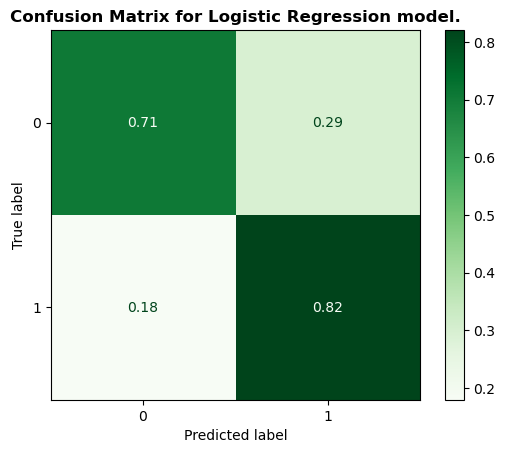

In [51]:
# Feature processing
## Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Train the model
lr = LogisticRegression(solver="newton-cholesky")
lr.fit(X_train_scaled, y_train)

# Get the results
y_hat = lr.predict(X_test_scaled)
pred_probs = lr.predict_proba(X_test_scaled)

# Let's get some metrics for the model
print(classification_report(y_test, y_hat))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat, normalize="true"))
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for Logistic Regression model.", fontweight='bold')
plt.show();

### Statistical Parity

We use our FairnessReport class to look at the group-wise results and check for fairness.

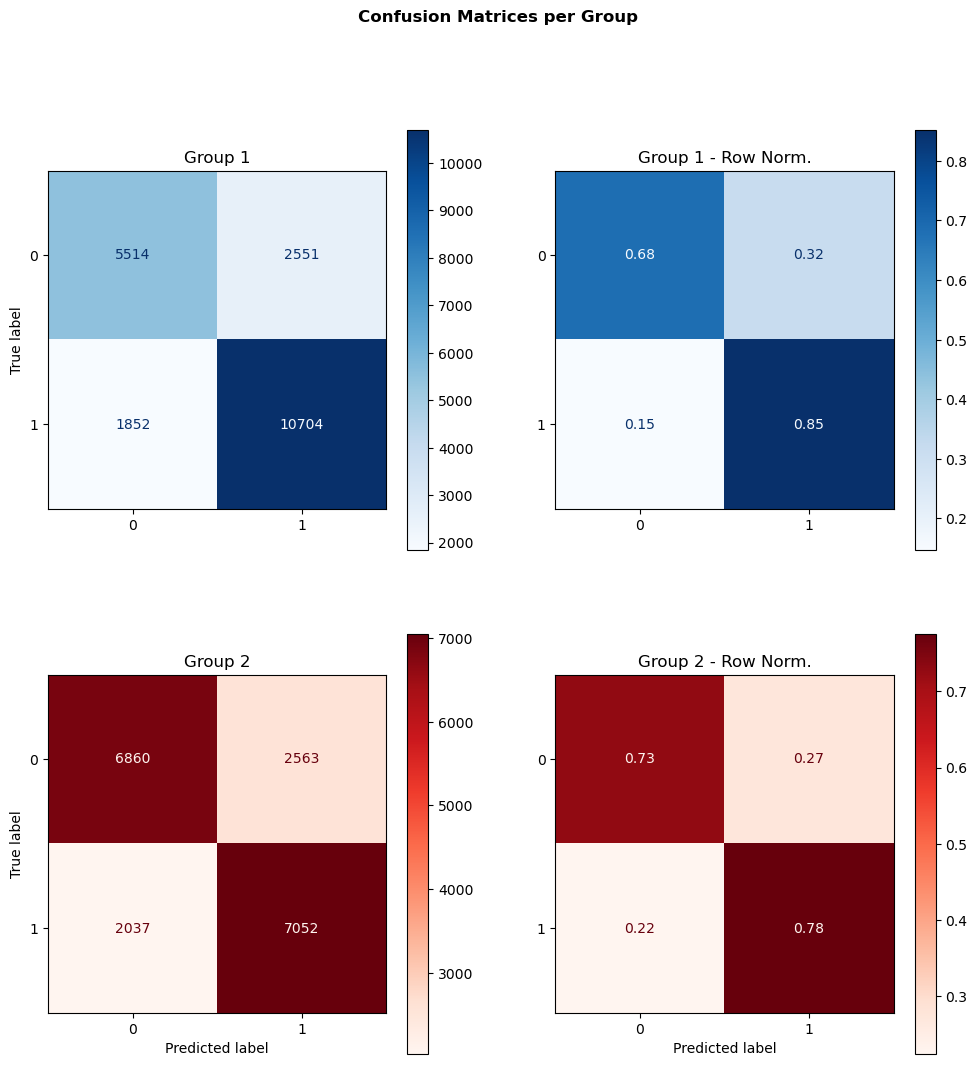

Statistical Parity: False -> (P(s=1 | G=1): 0.643 & P(s=1 | G=2): 0.519)
Equalized Odds: False -> TPR Group 1: 0.853 & TPR Group 2: 0.776 & FPR Group 1: 0.316 & FPR Group 2: 0.272
Equalized Outcomes: False -> P(T=1 | G=1,S=1): 0.808 & P(T=1 | G=2, S=1): 0.733 P(T=1 | G=1, S=0): 0.25142546836817814 & P(T=1 | G=2, S=0): 0.22895357985837922


In [53]:
fr = FairnessReport()
fr.fit(y_true = y_test, y_pred = y_hat, group = group_test, pred_prob = pred_probs)
fr.compute()

### ROC Curves per group

c:\Users\ginof\anaconda3\envs\AFAE\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\ginof\anaconda3\envs\AFAE\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


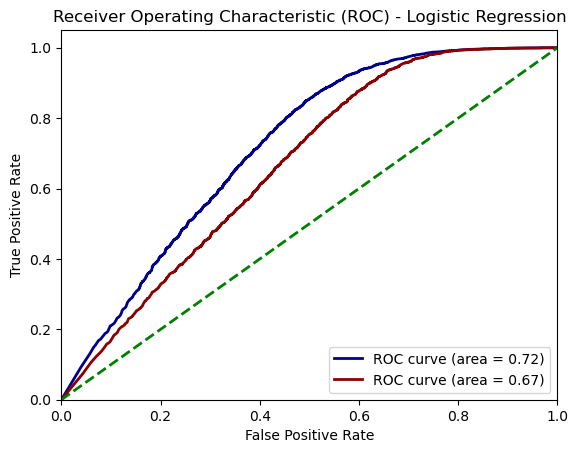

In [54]:
# Predict probabilities for the test set, group-wise
y_prob_G1= lr.predict_proba(X_test[group_test == 1])[:, 1]
y_prob_G2= lr.predict_proba(X_test[group_test == 2])[:, 1]

# Compute ROC curve and ROC area for each group
fpr1, tpr1, th1 = roc_curve(y_test[group_test == 1], y_prob_G1)
roc_auc1 = roc_auc_score(y_test[group_test == 1], y_prob_G1)
fpr2, tpr2, th2 = roc_curve(y_test[group_test == 2], y_prob_G2)
roc_auc2 = roc_auc_score(y_test[group_test == 2], y_prob_G2)

# Plot ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Ensuring Statistical Parity a posteriori

Since our model predicts TRUE with different rates, we will ensure statistical parity by turning those predictions closer to the threshold to TRUE, for the minority group

In [67]:
results = fr.get_results_table()
results_per_group = results[["group", "selected"]].groupby("group").sum("selected")
minority_group = results_per_group.idxmin().values[0]
diff = results_per_group.selected.max() - results_per_group.selected.min()

print(f"The minority group is {minority_group}, with {diff} less observations predicted as TRUE.")

results_per_group

The minority group is 2, with 3640 less observations predicted as TRUE.


,selected
group,
1,13255
2,9615


In [ ]:

np.vstack([tpr1, fpr1, th1]).T

array([[0.        , 0.        ,        inf],
       [0.0936604 , 0.0399256 , 1.        ],
       [0.1305352 , 0.05728456, 1.        ],
       ...,
       [0.99992036, 0.99950403, 0.99985979],
       [0.99992036, 1.        , 0.99984567],
       [1.        , 1.        , 0.99982953]])

In [ ]:
tpr1 = tpr1.round(2)
tpr2 = tpr2.round(2)
fpr1 = fpr1.round(2)
fpr2 = fpr2.round(2)
th1 = th1.round(5)
th2 = th2.round(5)

_1 = pd.DataFrame(np.vstack([tpr1, fpr1, th1]).T, columns=["TPR", "FPR", "TH1"])
_2 = pd.DataFrame(np.vstack([tpr2, fpr2, th2]).T, columns=["TPR", "FPR", "TH2"])

_ = _1.merge(_2, on=["TPR", "FPR"], how="inner").drop_duplicates()

_.sort_values("FPR")

,TPR,FPR,TH1,TH2
0,0.00,0.00,inf,inf
1,0.98,0.74,1.00000,1.00000
345,0.99,0.77,1.00000,1.00000
1306,0.99,0.78,1.00000,1.00000
2686,0.99,0.79,1.00000,1.00000
...,...,...,...,...
15768,1.00,1.00,0.99990,0.99980
15770,1.00,1.00,0.99990,0.99979
15829,1.00,1.00,0.99989,0.99985
15832,1.00,1.00,0.99989,0.99983


### Black-box model: Random Forest

              precision    recall  f1-score   support

       False       0.72      0.70      0.71     17488
        True       0.76      0.78      0.77     21645

    accuracy                           0.75     39133
   macro avg       0.74      0.74      0.74     39133
weighted avg       0.75      0.75      0.75     39133



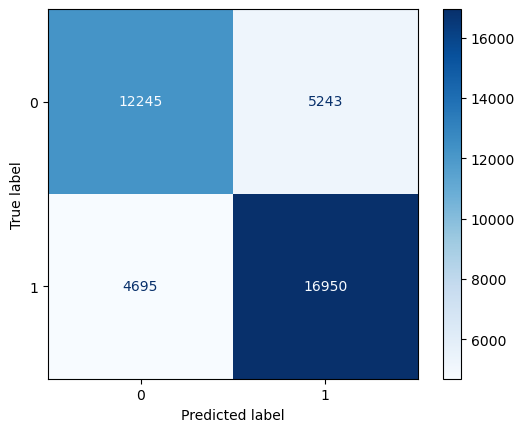

In [ ]:
# Train the model
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

# Get the results
y_hat = rf.predict(X_test)

# Let's get some metrics for the model
print(classification_report(y_test, y_hat))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat))
disp.plot(cmap=plt.cm.Blues)
plt.show();

In [ ]:
f = list(enumerate(rf.feature_importances_))
f.sort(key=lambda x: x[1], reverse=True)

In [ ]:
for feat in f[:10]:
    ix, val = feat
    print(list(data.columns)[ix])

AGEP
HINS1_2
HINS4_2
MAR_5
SEX_2
SCHL_22.0
SCHL_21.0
ENG_nan
HINS2_2
COW_6.0
